In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from io import StringIO

In [5]:
df = pd.read_csv('articels_dataset.csv')

In [8]:
df.head()

,Unnamed: 0,Category,Content,category_id
0,0,unrest,GANDHINAGAR: The state government's vaunted 'K...,0
1,1,unrest,"CHANDIGARH: To avoid further embarrassment, th...",0
2,2,unrest,"LUCKNOW: A committed RSS pracharak since 1977,...",0
3,3,unrest,Sangam: At a time when Allahabad is playing ho...,0
4,4,unrest,"CHENNAI: As news of the violence spread, the a...",0


In [7]:
df['category_id'] = df['Category'].factorize()[0]

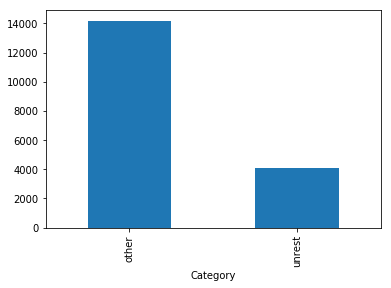

In [5]:
df.groupby('Category').Content.count().plot.bar(ylim=0)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')


In [11]:
features = tfidf.fit_transform(df.Content.values.astype('U')).toarray()
labels = df.category_id

In [12]:
features.shape

(18471, 97487)

In [10]:
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

In [11]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'other':
  . Most correlated unigrams:
       . protest
       . nan
       . murder
       . government
       . police
  . Most correlated bigrams:
       . city police
       . police said
       . state government
       . said police
       . police station
# 'unrest':
  . Most correlated unigrams:
       . protest
       . nan
       . murder
       . government
       . police
  . Most correlated bigrams:
       . city police
       . police said
       . state government
       . said police
       . police station


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [13]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.872394
MultinomialNB             0.789833
RandomForestClassifier    0.778464
Name: accuracy, dtype: float64

In [15]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

In [27]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
y_pred = model.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)

In [33]:
accuracy

0.87171916010498685

In [35]:
model.fit(features,labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
from sklearn.feature_selection import chi2

N = 5
category = "unrest"
indices = np.argsort(model.coef_[0]) 
feature_names = np.array(tfidf.get_feature_names())[indices]
unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
print("# '{}':".format(category))
print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'unrest':
  . Top unigrams:
       . nan
       . candidates
       . university
       . rammed
       . sunday
  . Top bigrams:
       . navi mumbai
       . water supply
       . official said
       . court monday
       . political parties
